# Building a Generic RK Solver

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import time
import scipy.optimize
from scipy.spatial.transform import Rotation

In [2]:
@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def norm(a):
	return a/vecLen(a)

@numba.jit
def BPrime(B, E, v, gamma, c):
	return gamma * B + (1-gamma)*np.dot(B, v)*v/np.dot(v)-gamma/c**2.0*np.cross(v, E)

@numba.jit
def WT(gamma, c, a, v):
	return gamma**2.0/(c**2.0 * (gamma+1))*np.cross(a, v)

@numba.jit
def updateSpin(s, v, B0, E0, consts):
	s = norm(s)
	#this is the base iteration function, the idea is to shift all the values by one step each time this is called
	B = B0+np.cross(E0, v/89875517873681764.0) #big number is the speed of light squared in m^2/s^2
	#update the spin
	crossVal = consts['gamma']*B+2.0*(consts['dn']/consts['hbar'])*E0
	s = np.cross(crossVal, s)
	return s

# Finds value of y for a given x using step size h
@numba.jit
def rungeKutta(function, rkA, rkB, rkC, initSpin, h, numIter, V, B0, E0, consts):
	# Count number of iterations using step size or
	# step height h
	#how many k calculations are there
	y0 = np.copy(initSpin)
	s = len(rkC)
	allSpins = None
	allSpins = [y0]
	for n in range(numIter):
		k = [function(y0, v, B0, E0, consts)]
		for i in range(1, s):
			temp = np.zeros(y0.shape)
			for j in range(1, i):
				temp+=rkA[i][j]*k[j]
			k.append(function(y0+h*temp, v, B0, E0, consts))
		t = np.zeros(y0.shape)
		for i in range(s):
			t+=rkB[i]*k[i]
		y0 = y0 + h*t
		y0 = norm(y0)
		allSpins.append(y0)
	return allSpins

def forwardEuler():
	rkA = np.array([[0]])
	rkB = np.array([1])
	rkC = np.array([0])
	return rkA, rkB, rkC

def midpointMethod():
	rkA = np.array([[0, 0], [0.5, 0]])
	rkB = np.array([0, 1])
	rkC = np.array([0, 0.5])
	return rkA, rkB, rkC

def RK3():
	rkA = np.array([[0, 0, 0], [0.5, 0, 0], [-1, 2, 0]])
	rkB = np.array([1.0/6.0, 2.0/3.0, 1.0/6.0])
	rkC = np.array([0.0, 0.5, 1.0])
	return rkA, rkB, rkC

def RK4():
	rkA = np.array([[0, 0, 0, 0], [0.5, 0, 0, 0], [0, 0.5, 0, 0], [0, 0, 1, 0]])
	rkB = np.array([1.0/6.0, 1.0/3.0, 1.0/3.0, 1.0/6.0])
	rkC = np.array([0, 0.5, 0.5, 1.0])
	return rkA, rkB, rkC

def RK45():
	rkA = np.array([[0, 0, 0, 0, 0], 
		   [1/4, 0, 0, 0, 0],
		   [3/32, 9/32, 0, 0, 0],
		   [1932/2197, -7200/2197, 7296/2197, 0, 0],
		   [439/216, -8, 3680/513, -845/4140, 0],
		   [-8/27, 2, -3544/2565, 1859/4104, -11/40]])
	rkB = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])
	rkC = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])
	return rkA, rkB, rkC

def CashKarp6_4_5():
	rkA = np.array([[0, 0, 0, 0, 0, 0],
		   [1/5, 0, 0, 0, 0, 0],
		   [3/40, 9/40, 0, 0, 0, 0],
		   [3/10, -9/10, 6/5, 0, 0, 0],
		   [-11/54, 5/2, -70/27, 35/2, 0, 0],
		   [1631/55296, 175/512, 575/13824, 44275/110592, 253/4096, 0]])
	rkB = np.array([37/378, 0, 250/621, 125/594, 0, 512/1771])
	rkC = np.array([0, 1/5, 3/10, 3/5, 1, 7/8])
	return rkA, rkB, rkC

In [3]:
precision = np.float64
neutType = np.dtype([('x', precision, 3), ('v', precision, 3), ('s', precision, 3)])

constType = np.dtype([('m', precision), ('dn', precision), ('gamma', precision), ('hbar', precision)])
consts = np.array(1, dtype=constType)
consts['m']=1.674927485E-27 #units of kg
consts['dn'] = 0.0
consts['gamma'] = -1.83247171E8
consts['hbar'] = 1.054571817E-34

#E = np.array([0, 0, 75.0E5], dtype=precision)
E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-7], dtype=precision)
s = np.array([1, 0, 0], dtype=precision)
v = np.array([0, 0, 0], dtype=precision)

In [4]:
#initial runs to get the JIT compilation out of the way
h = 1
num = 1
rungeKutta(updateSpin, *forwardEuler(), np.copy(s), h, num, v, B, E, consts)
rungeKutta(updateSpin, *midpointMethod(), np.copy(s), h, num, v, B, E, consts)
rungeKutta(updateSpin, *RK3(), np.copy(s), h, num, v, B, E, consts)
rungeKutta(updateSpin, *RK4(), np.copy(s), h, num, v, B, E, consts)
rungeKutta(updateSpin, *RK45(), np.copy(s), h, num, v, B, E, consts)
rungeKutta(updateSpin, *CashKarp6_4_5(), np.copy(s), h, num, v, B, E, consts)
None

In [5]:
w = consts['gamma']*vecLen(B) #calculate the frequency
period = abs(2.0*np.pi/w)
numSteps = np.logspace(0, 5, 10).astype(int)
finalPositions = []
executionTimes = []

for num in numSteps:
	t = []
	h = period/num
	start = time.time()
	spinsEuler = rungeKutta(updateSpin, *forwardEuler(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	start = time.time()
	spinsMidpoint = rungeKutta(updateSpin, *midpointMethod(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	start = time.time()
	spinsRK3 = rungeKutta(updateSpin, *RK3(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	start = time.time()
	spinsRK4 = rungeKutta(updateSpin, *RK4(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	start = time.time()
	spinsRK45 = rungeKutta(updateSpin, *RK45(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	start = time.time()
	spinsCK645 = rungeKutta(updateSpin, *CashKarp6_4_5(), np.copy(s), h, num, v, B, E, consts)
	t.append(time.time()-start)
	
	finalPositions.append((spinsEuler[-1], spinsMidpoint[-1], spinsRK3[-1], spinsRK4[-1], spinsRK45[-1], spinsCK645[-1]))
	executionTimes.append(t)
finalPositions = np.array(finalPositions)
executionTimes = np.array(executionTimes)
labels = ['Euler', 'Midpoint', 'RK3', 'RK4', 'RK45', 'CK645']

In [6]:
errors = abs(finalPositions[:,:,0]-1.0)**2.0+abs(finalPositions[:,:,1]-0.0)**2.0

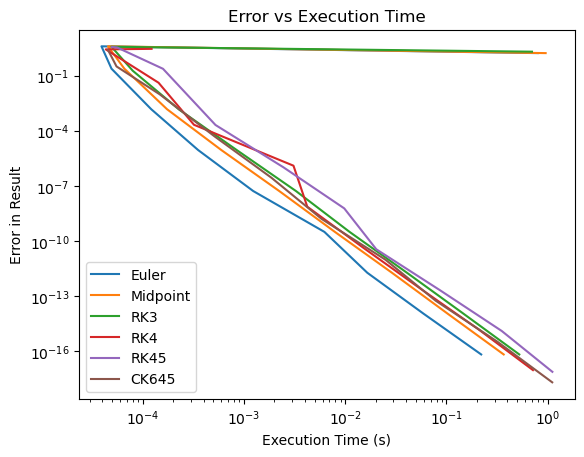

In [7]:
plt.plot(executionTimes, errors, label=labels)
plt.title('Error vs Execution Time')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Execution Time (s)')
plt.ylabel('Error in Result')
plt.legend()
plt.show()

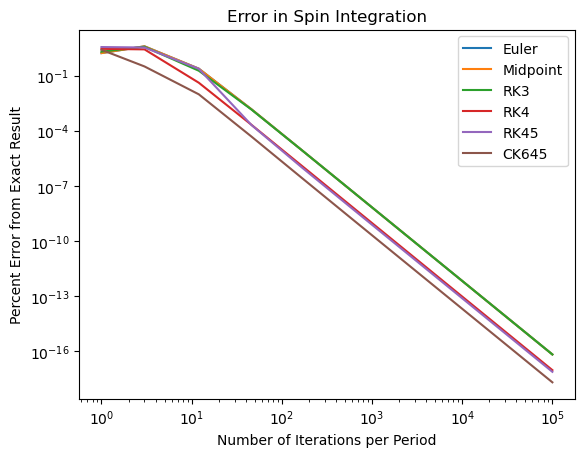

In [8]:
plt.plot(numSteps, abs(finalPositions[:,:,0]-1.0)**2.0+abs(finalPositions[:,:,1]-0.0)**2.0, label=labels)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title('Error in Spin Integration')
plt.xlabel('Number of Iterations per Period')
plt.ylabel('Percent Error from Exact Result')
plt.show()

## What does this suggest?
This suggests that it is possible with the Euler method to reach a more precise result in less time than it is with the other methods. It may require more iterations, but because each calculation is so simple it's not actually slower to do it this way.

## Test to see how many iterations it takes per period

In [103]:
@numba.jit
def sinFunc(t):
	return np.sin(2.0*np.pi/10*t)

def sinFuncRunge(t, x, args=None):
	return np.sin(2.0*np.pi/10*t)

def rungeKuttaGeneric(function, init, numIter, h, rkA, rkB, rkC, args = None):
	# Count number of iterations using step size or
	# step height h
	s = len(rkC)
	init = np.array(init)
	results = [init]
	for n in range(numIter):
		k = [function(*init)]
		for i in range(1, s):
			temp = 0
			for j in range(1, i):
				temp+=rkA[i][j]*k[j]
			t = y0+h*
			k.append(function(y0+h*temp))
		t = 0
		for i in range(s):
			t+=rkB[i]*k[i]
		print(y0, t)
		y0 = y0 + h*t
		#y0 = norm(y0)
		allSpins.append(y0)
	return allSpins

In [107]:
xvals = np.linspace(0, 10, 100)
yvals = []
for x in xvals:
	yvals.append(scipy.integrate.quad(sinFunc, 0, x)[0])
res2 = rungeKuttaSin(sinFuncRunge, *forwardEuler(), 0.0, np.diff(xvals)[0], 100, v, B, E, consts)

0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0
0.0 0.0
0.0


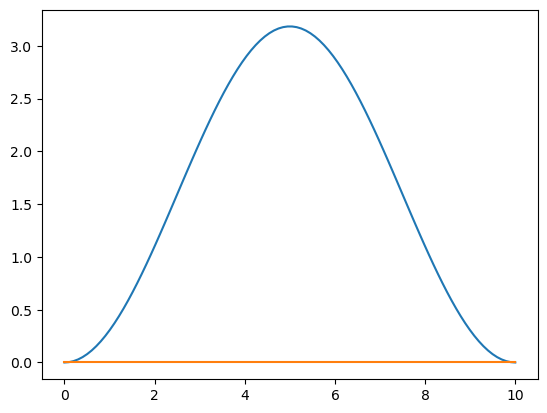

In [108]:
plt.plot(xvals, yvals)
plt.plot(xvals, res2[:-1])
plt.show()

In [45]:
E = np.array([0, 0, 75.0E5], dtype=precision)
#E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-7], dtype=precision)
s = np.array([1, 0, 0], dtype=precision)
v = np.array([0, 0, 0], dtype=precision)
w = consts['gamma']*vecLen(B) #calculate the frequency
period = abs(2.0*np.pi/w)

numSteps = np.logspace(0, 4, num=40, endpoint=True).astype(int)
numSteps = np.sort(np.unique(numSteps))

spinsEuler = []
spinsMidpoint = []
spinsRK3 = []
spinsRK4 = []
spinsRK45 = []
spinsCK645 = []
timeScales = []
sinIntegrator = []

for numIter in numSteps:
	timeScale = np.linspace(0, period, numIter+1)
	h = np.diff(timeScale)[0]
	timeScales.append(timeScale)
	spinsEuler.append(np.array(rungeKutta(updateSpin, *forwardEuler(), np.copy(s), h, numIter, v, B, E, consts)))
	spinsMidpoint.append(np.array(rungeKutta(updateSpin, *midpointMethod(), np.copy(s), h, numIter, v, B, E, consts)))
	spinsRK3.append(np.array(rungeKutta(updateSpin, *RK3(), np.copy(s), h, numIter, v, B, E, consts)))
	spinsRK4.append(np.array(rungeKutta(updateSpin, *RK4(), np.copy(s), h, numIter, v, B, E, consts)))
	spinsRK45.append(np.array(rungeKutta(updateSpin, *RK45(), np.copy(s), h, numIter, v, B, E, consts)))
	spinsCK645.append(np.array(rungeKutta(updateSpin, *CashKarp6_4_5(), np.copy(s), h, numIter, v, B, E, consts)))
	sinIntegrator.append(np.array(rungeKutta(sinFunc, *forwardEuler(), np.copy(s), h, numIter, 0.1, B, E, consts)))

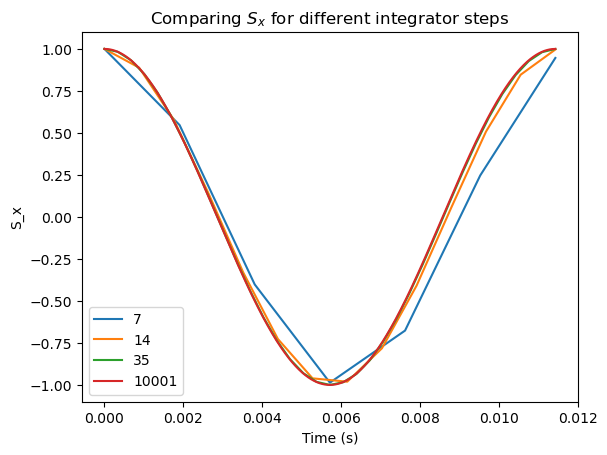

In [18]:
demoLocs = [5, 8, 12, -1]
for loc in demoLocs:
	plt.plot(timeScales[loc], spinsCK645[loc][:,0], label=len(timeScales[loc]))
plt.legend()
plt.title(r'Comparing $S_x$ for different integrator steps')
plt.ylabel(r'S_x')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
S = S + h*AxS

In [11]:
period

0.01142934480769253

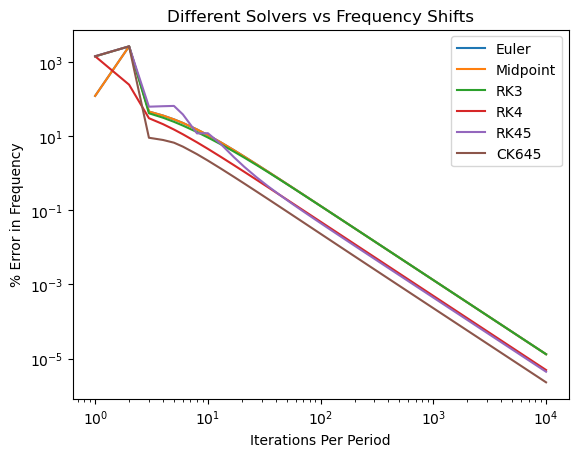

In [12]:
def func(t, w):
	return np.cos(w*t)
w = abs(w)
fitResEul = []
for t, r in zip(timeScales, spinsEuler):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResEul.append(abs(popt[0]-w)/w*100)

fitResMid = []
for t, r in zip(timeScales, spinsMidpoint):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResMid.append(abs(popt[0]-w)/w*100)

fitResRK3 = []
for t, r in zip(timeScales, spinsRK3):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResRK3.append(abs(popt[0]-w)/w*100)

fitResRK4 = []
for t, r in zip(timeScales, spinsRK4):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResRK4.append(abs(popt[0]-w)/w*100)

fitResRK45 = []
for t, r in zip(timeScales, spinsRK45):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResRK45.append(abs(popt[0]-w)/w*100)

fitResCK645 = []
for t, r in zip(timeScales, spinsCK645):
	popt, pcov = scipy.optimize.curve_fit(func, t, r[:,0], p0=[w])
	fitResCK645.append(abs(popt[0]-w)/w*100)


plt.plot(numSteps, fitResEul, label='Euler')
plt.plot(numSteps, fitResMid, label='Midpoint')
plt.plot(numSteps, fitResRK3, label='RK3')
plt.plot(numSteps, fitResRK4, label='RK4')
plt.plot(numSteps, fitResRK45, label='RK45')
plt.plot(numSteps, fitResCK645, label='CK645')
plt.title('Different Solvers vs Frequency Shifts')
plt.ylabel('% Error in Frequency')
plt.xlabel('Iterations Per Period')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()

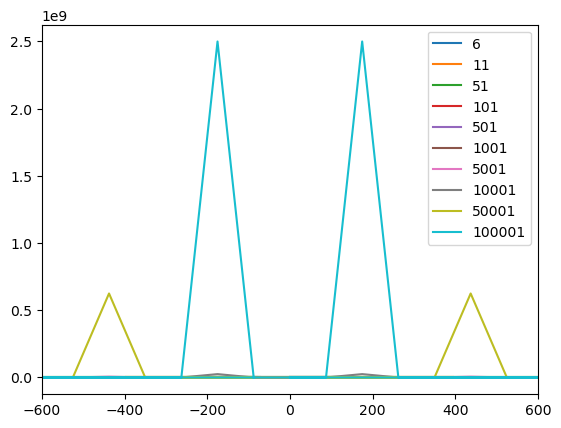

In [141]:
for t, r in zip(timeScales, spinsEuler):
	plt.plot(np.fft.fftfreq(len(r[:,0]), d=np.diff(t)[0]), np.fft.fft(r[:,0])**2.0, label=len(t))
plt.xlim(-600, 600)
plt.legend()

In [100]:
numIter = 10000000
length = 1.0/abs(w)
timeScale = np.linspace(0, length, numIter+1, endpoint=True)

In [101]:
spinsEuler = np.array(rungeKutta(updateSpin, *forwardEuler(), np.copy(s), h, numIter, v, B, E, consts))

In [102]:
spinsMidpoint = np.array(rungeKutta(updateSpin, *midpointMethod(), np.copy(s), h, numIter, v, B, E, consts))

In [103]:
spinsRK3 = np.array(rungeKutta(updateSpin, *RK3(), np.copy(s), h, numIter, v, B, E, consts))

In [104]:
spinsRK4 = np.array(rungeKutta(updateSpin, *RK4(), np.copy(s), h, numIter, v, B, E, consts))

In [105]:
spinsRK45 = np.array(rungeKutta(updateSpin, *RK45(), np.copy(s), h, numIter, v, B, E, consts))

In [106]:
spinsCK645 = np.array(rungeKutta(updateSpin, *CashKarp6_4_5(), np.copy(s), h, numIter, v, B, E, consts))

In [107]:
def calcTotalError(truthX, truthY, calc):
	errX = truthX - calc[:,0]
	errY = truthY - calc[:,1]
	return np.sqrt(errX**2.0 + errY**2.0)

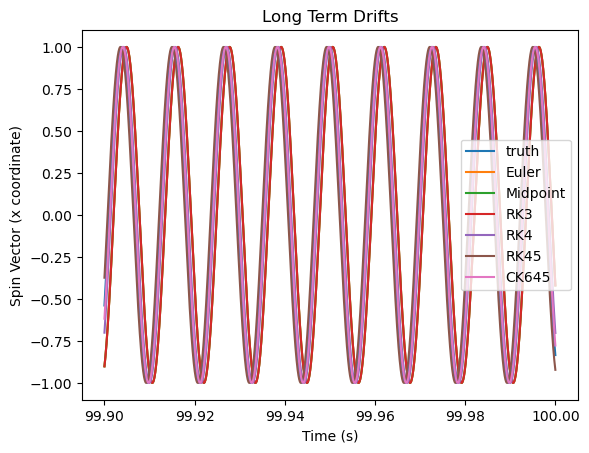

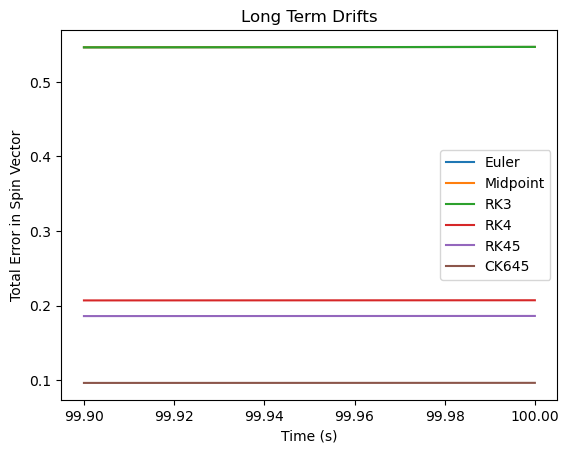

In [114]:
trueSolutionX = np.cos(w*timeScale)
trueSolutionY = -1*np.sin(w*timeScale)

startT = 99.9
stopT = 100
xLow = timeScale>startT
xHigh = timeScale<stopT
locs = np.logical_and(xLow, xHigh)

plt.plot(timeScale[locs], trueSolutionX[locs], label='truth')
plt.plot(timeScale[locs], spinsEuler[:,0][locs], label='Euler')
plt.plot(timeScale[locs], spinsMidpoint[:,0][locs], label='Midpoint')
plt.plot(timeScale[locs], spinsRK3[:,0][locs], label='RK3')
plt.plot(timeScale[locs], spinsRK4[:,0][locs], label='RK4')
plt.plot(timeScale[locs], spinsRK45[:,0][locs], label='RK45')
plt.plot(timeScale[locs], spinsCK645[:,0][locs], label='CK645')
plt.title('Long Term Drifts')
plt.xlabel('Time (s)')
plt.ylabel('Spin Vector (x coordinate)')
#plt.xlim(0.9, 1)
plt.legend()
plt.show()

plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsEuler)[locs], label='Euler')
plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsMidpoint)[locs], label='Midpoint')
plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsRK3)[locs], label='RK3')
plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsRK4)[locs], label='RK4')
plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsRK45)[locs], label='RK45')
plt.plot(timeScale[locs], calcTotalError(trueSolutionX, trueSolutionY, spinsCK645)[locs], label='CK645')
#plt.xlim()
plt.title('Long Term Drifts')
plt.xlabel('Time (s)')
plt.ylabel('Total Error in Spin Vector')
plt.legend()
plt.show()

## Can I see a trend by looking at what happens to the small deviations between each iteration?


In [22]:
# Finds value of y for a given x using step size h
@numba.jit
def rungeKuttaReturnDev(function, rkA, rkB, rkC, initSpin, h, numIter, V, B0, E0, consts):
	# Count number of iterations using step size or
	# step height h
	#how many k calculations are there
	y0 = np.copy(initSpin)
	s = len(rkC)
	allSpins = None
	allSpins = [y0]
	allDevs = [np.zeros(3)]
	for n in range(numIter):
		k = [function(y0, v, B0, E0, consts)]
		for i in range(1, s):
			temp = np.zeros(y0.shape)
			for j in range(1, i):
				temp+=rkA[i][j]*k[j]
			k.append(function(y0+h*temp, v, B0, E0, consts))
		t = np.zeros(y0.shape)
		for i in range(s):
			t+=rkB[i]*k[i]
		y0 = y0 + h*t
		allDevs.append(h*t)
		y0 = norm(y0)
		allSpins.append(y0)
	return allSpins, allDevs

In [23]:
E = np.array([0, 0, 75.0E5], dtype=precision)
#E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-7], dtype=precision)
s = np.array([1, 0, 0], dtype=precision)
v = np.array([0, 0, 0], dtype=precision)
w = consts['gamma']*vecLen(B) #calculate the frequency
period = abs(2.0*np.pi/w)
numIter = 10000000
length = 1.0/abs(w)
timeScale = np.linspace(0, length, numIter+1, endpoint=True)

In [24]:
spinsEuler, devsEuler = rungeKuttaReturnDev(updateSpin, *forwardEuler(), np.copy(s), h, numIter, v, B, E, consts)
spinsEuler = np.array(spinsEuler)
devsEuler = np.array(devsEuler)

## Testing some Gaussian Integration
These depend on being able to put it into the following form

Integral (dx/dt) = x

Because of this we need to somehow get ds/dt = A x s to something like B ds/dt = S

Bold Claim: Because a vector as a quaternion means (Vx, Vy, Vz)-> (0, Vx, Vy, Vz), we can say that ds/dt = A * S or integral(1/A * ds/dt) = S

This is a very bold claim and I'm not sure if it's accurate or not yet

In [26]:
@numba.jit
def vecLen(a):
	return np.sqrt(np.sum(np.square(a)))

@numba.jit
def norm(a):
	return a/vecLen(a)

@numba.jit
def BPrime(B, E, v, gamma, c):
	return gamma * B + (1-gamma)*np.dot(B, v)*v/np.dot(v)-gamma/c**2.0*np.cross(v, E)

@numba.jit
def WT(gamma, c, a, v):
	return gamma**2.0/(c**2.0 * (gamma+1))*np.cross(a, v)

@numba.jit
def calculateSpinAdjustQuat(s, v, B0, E0, consts):
	s = norm(s)
	#this is the base iteration function, the idea is to shift all the values by one step each time this is called
	B = B0+np.cross(E0, v/89875517873681764.0) #big number is the speed of light squared in m^2/s^2
	#update the spin
	crossVal = consts['gamma']*B+2.0*(consts['dn']/consts['hbar'])*E0
	return crossVal

@numba.jit
def qMult(q1, q2):
	w1, x1, y1, z1 = q1
	w2, x2, y2, z2 = q2
	w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
	x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
	y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
	z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
	return np.array([w, x, y, z], dtype=q1.dtype)

In [27]:
E = np.array([0, 0, 75.0E5], dtype=precision)
#E = np.array([0, 0, 0], dtype=precision)
B = np.array([0, 0, 30.0E-7], dtype=precision)
s = np.array([1, 0, 0], dtype=precision)
v = np.array([0, 0, 0], dtype=precision)
w = consts['gamma']*vecLen(B) #calculate the frequency
period = abs(2.0*np.pi/w)
numIter = 10000
timeScale = np.linspace(0, period, numIter+1, endpoint=True)
h = np.diff(timeScale)[0]

In [28]:
rotations = []
for t in timeScale:
	rotations.append(calculateSpinAdjustQuat(s, v, B, E, consts))

spinsEuler, devsEuler = rungeKuttaReturnDev(updateSpin, *forwardEuler(), np.copy(s), h, numIter, v, B, E, consts)

In [31]:
def determineMatrix(s, h):
	return np.array([[1, -h*s[2], h*s[1]], [h*s[2], 1, -h*s[0]], [-h*s[1], h*s[0], 1]])

In [ ]:
'''S' = S + h*AxS
S' = S + h*A'S
S' = (1+h*A)S'''

"S' = S + h*AxS\nS' = S + h*A'S\nS' = (1+h*A)S"

In [32]:
matrix = determineMatrix(rotations[0], h)
qr = np.linalg.qr(matrix)
rot = Rotation.from_matrix(matrix)

In [39]:
rot.as_euler('XYZ')

array([ 0.        ,  0.        , -0.00062832])

In [33]:
mat = rot.as_matrix()

In [34]:
curVec = [s]
for i in range(numIter):
	curVec.append(np.matmul(mat, curVec[i]))
curVec = np.array(curVec)

(0.0, 0.01142934480769253)

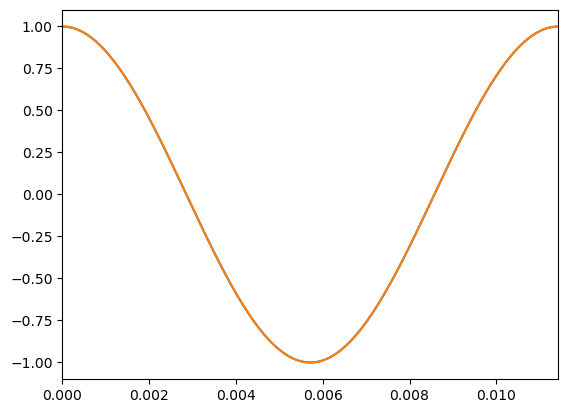

In [409]:
plt.plot(timeScale, curVec[:,0])
plt.plot(timeScale, np.array(spinsEuler)[:,0])
plt.xlim(0, period)

In [317]:
np.sum(np.square(matrix))

3.0002

In [318]:
np.sum(np.square(qr[0]))

3.0